In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import itertools
from tqdm import tqdm

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
%config InlineBackend.figure_formats = ['svg']

project_dir = os.path.expanduser('~/RL_2024/')

In [15]:
γ = 0.99  # discount factor for policy learning

nS = 750
nA = 25

nS_term = 2
S_survival = 750
S_death = 751

nS_total = nS + nS_term

In [ ]:
with open(project_dir + 'data/env_model/gymP_orig.pkl', 'rb') as f:
    gymP_orig = pickle.load(f)
with open(project_dir + 'data/env_model/gymP_dropped.pkl', 'rb') as f:
    gymP_dropped = pickle.load(f)
with open(project_dir + 'data/env_model/gymP_shifted.pkl', 'rb') as f:
    gymP_shifted = pickle.load(f)

π_b_orig = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_orig.pkl').values
π_b_dropped = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_dropped.pkl').values
π_b_shifted = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_shifted.pkl').values

SA_mask_orig = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_orig.pkl').values
SA_mask_dropped = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_dropped.pkl').values
SA_mask_shifted = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_shifted.pkl').values

In [ ]:
def value_iteration_masked(gymP, nS, nA, SA_mask, gamma, threshold=1e-10):
    Vs = []
    V = np.zeros(nS)
    Vs.append(V.copy())
    for _ in tqdm(itertools.count()):
        V_new = V.copy()
        for s in range(nS):
            ## V[s] = max {a} sum {s', r} P[s', r | s, a] * (r + gamma * V[s'])
            Q_s = np.zeros((nA))
            for a in range(nA):
                Q_s[a] = sum(p * (r + (0 if done else gamma * V[s_])) for p, s_, r, done in gymP[s][a])
            Q_s[~SA_mask[s]] = np.nan
            new_v = np.nanmax(Q_s)
            V_new[s] = new_v
        if np.isclose(np.linalg.norm(V_new - V), threshold):
            break
        V = V_new
        Vs.append(V_new)
    return V, {
        'V': V,
        'Vs': Vs,
    }

In [ ]:
V_orig, info_orig = value_iteration_masked(gymP_orig, nS, nA, SA_mask_orig, γ)

130it [00:06, 18.60it/s]


In [8]:
V_dropped, info_dropped = value_iteration_masked(gymP_dropped, nS, nA, SA_mask_dropped, γ)

126it [00:06, 20.69it/s]


In [9]:
V_shifted, info_shifted = value_iteration_masked(gymP_shifted, nS, nA, SA_mask_shifted, γ)

140it [00:06, 20.42it/s]


In [10]:
with open(project_dir + 'data/value_funcs/VI_orig__Vs.pkl', 'wb') as f:
    pickle.dump(info_orig['Vs'], f)
with open(project_dir + 'data/value_funcs/VI_dropped__Vs.pkl', 'wb') as f:
    pickle.dump(info_dropped['Vs'], f)
with open(project_dir + 'data/value_funcs/VI_shifted__Vs.pkl', 'wb') as f:
    pickle.dump(info_shifted['Vs'], f)

In [11]:
opacity = 0.8

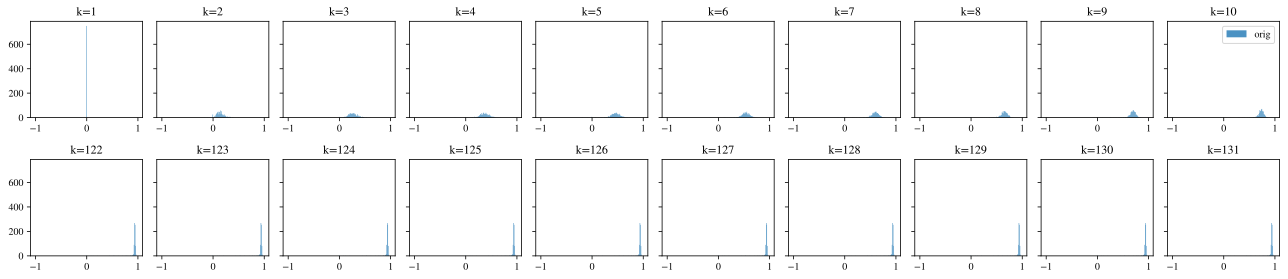

In [16]:
# Learning progress of VI, plotting the V at k-th iteration
name = 'orig'
fig, axes = plt.subplots(2,10, figsize=(18,4), sharey=True)
for t in range(10):
    axes[0,t].hist(info_orig['Vs'][t].flatten(), bins=np.arange(-1, 1, 0.01), alpha=opacity, label=name)
    axes[0,t].set_title(f'k={t+1}')
length = min([len(info_orig['Vs'])])
for i, t in zip(range(10), range(length-10, length)):
    axes[1,i].hist(info_orig['Vs'][t].flatten(), bins=np.arange(-1, 1, 0.01), alpha=opacity, label=name)
    axes[1,i].set_title(f'k={t+1}')
axes[0,-1].legend()
plt.tight_layout()
plt.show()

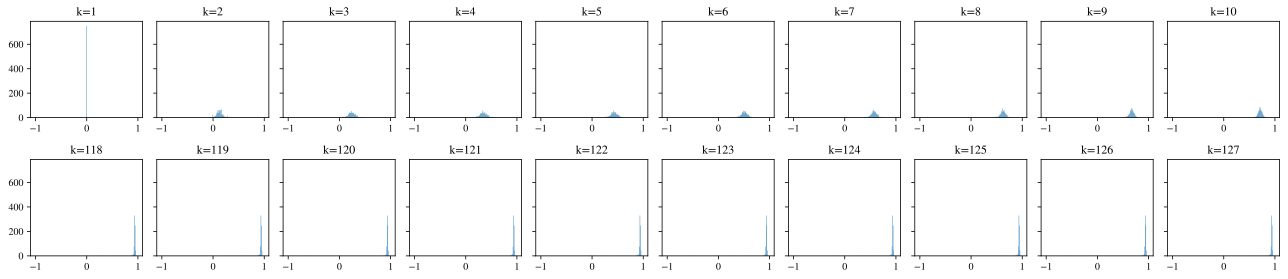

In [22]:
# Learning progress of VI, plotting the V at k-th iteration
name = 'dropped'
color = 'tab:blue'
fig, axes = plt.subplots(2,10, figsize=(18,4), sharey=True)
for t in range(10):
    axes[0,t].hist(info_dropped['Vs'][t].flatten(), bins=np.arange(-1, 1, 0.01), fc=color, alpha=opacity, label=name)
    axes[0,t].set_title(f'k={t+1}')
length = min([len(info_dropped['Vs'])])
for i, t in zip(range(10), range(length-10, length)):
    axes[1,i].hist(info_dropped['Vs'][t].flatten(), bins=np.arange(-1, 1, 0.01), fc=color, alpha=opacity, label=name)
    axes[1,i].set_title(f'k={t+1}')
# axes[0,-1].legend()
plt.tight_layout()
plt.savefig(project_dir + 'figures/VI__Vs_dropped.pdf', bbox_inches='tight')
plt.show()

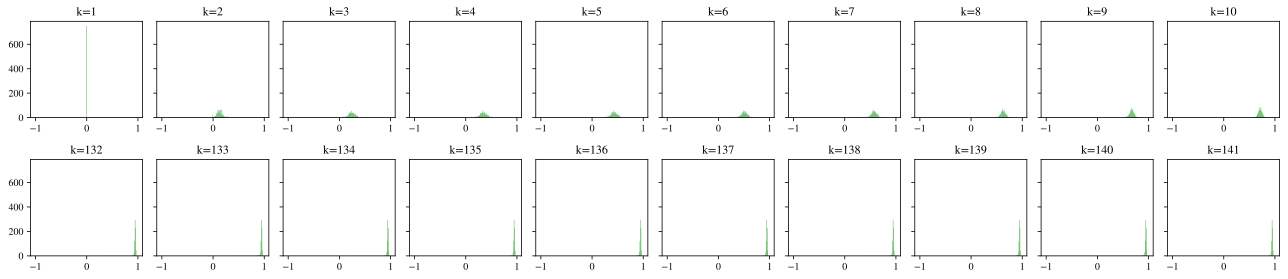

In [23]:
# Learning progress of VI, plotting the V at k-th iteration
name = 'shifted'
color = 'tab:green'
fig, axes = plt.subplots(2,10, figsize=(18,4), sharey=True)
for t in range(10):
    axes[0,t].hist(info_dropped['Vs'][t].flatten(), bins=np.arange(-1, 1, 0.01), fc=color, alpha=opacity, label=name)
    axes[0,t].set_title(f'k={t+1}')
length = min([len(info_shifted['Vs'])])
for i, t in zip(range(10), range(length-10, length)):
    axes[1,i].hist(info_shifted['Vs'][t].flatten(), bins=np.arange(-1, 1, 0.01), fc=color, alpha=opacity, label=name)
    axes[1,i].set_title(f'k={t+1}')
# axes[0,-1].legend()
plt.tight_layout()
plt.savefig(project_dir + 'figures/VI__Vs_shifted.pdf', bbox_inches='tight')
plt.show()